In [86]:
%matplotlib inline

In [179]:
import glob
import os
import subprocess
import ast
import random
from collections import defaultdict

import matplotlib.pyplot as plt
import pandas as pd
from Levenshtein import distance
from sklearn.feature_extraction.text import TfidfVectorizer
import seaborn as sns

from utils import stopwords

pd.set_option('display.max_columns', 200)
pd.set_option('display.max_rows', 200)
pd.set_option('display.max_colwidth', 100)

### co-occurrence

```
how many people live in austin ?
how many people live in oregon ?

_answer ( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( austin , _ ) ) ) )
_answer ( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( oregon , _ ) ) ) )

---
'what is the highest point in ohio ?'
'what is the highest elevation in oklahoma ?'
'_answer ( NV , _highest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( ohio ) ) ) ) )'
'_answer ( NV , _highest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( oklahoma ) ) ) ) )'

---
fails:
- list the states ?
- list the california ?

- _answer ( NV , _state ( V0 ) )

```

### analysis

In [37]:
!rm *.csv

In [ ]:
# last good csv results_4f90e6569dc54a358790efc5afc32f73.csv

In [190]:
!scp scicomp2:$(ssh scicomp2 'ls -t cs224n-project/results/*.csv | head -1') results/

results_5b23f72f074244c590c082830dab3a68.csv  100%   45KB 127.5KB/s   00:00    


In [223]:
df_results = pd.read_csv(max(glob.glob('results/*.csv'), key=os.path.getctime))
df_results = df_results.set_index('runner_uuid')

In [225]:
df_results.shape

(144, 31)

In [226]:
cols_hps = [
    'augment',
    'decoder_type',
    'pre_train',
    'lr',
    'hidden_size',
    'embed_size'
]
cols_accuracy = ['sequence_correct', 'sequence_accuracy', 'token_accuracy']
cols = cols_hps + cols_accuracy

In [239]:
df_results_out = df_results[cols].sort_values(by='sequence_accuracy', ascending=False)
df_results_out.head(10)

,augment,decoder_type,pre_train,lr,hidden_size,embed_size,sequence_correct,sequence_accuracy,token_accuracy
runner_uuid,,,,,,,,,
8d33dfe693c27efa4177eff0c1a334c45535947b9ab081b8fcbd696a,nesting+entity+concat2,rnn,True,0.001,256,64,208,0.742857,0.877250
0c208440943c7ab4dd9772307506d5e532b3be198aa5203dd42ce335,nesting+entity+concat2,rnn,False,0.001,256,64,206,0.735714,0.882488
88fc6bd01189994598d057d1d5cf686385c4849e44f8a7ca2c18cf44,nesting+entity+concat2,rnn,False,0.010,256,128,201,0.717857,0.870486
c136ac0719c850eff32c09b178d389131908688109ed2e431d44cd2a,nesting+entity+concat2,rnn,True,0.001,256,128,200,0.714286,0.867540
3bb040364cd49b4e23ad350ef69e7681a3bcbb902225e9ba96ed38c8,nesting+entity+concat2,rnn,False,0.010,256,64,199,0.710714,0.875286
9f8ffe2c5262ba2dc42153c37639962c3527555ba17dde7a6ca69831,nesting+entity+concat2,rnn,False,0.001,256,32,199,0.710714,0.876159
36753bf6beb6e9d4bfbfeb44eb32ec3af9847ac51be21671a1c5200a,nesting+entity+concat2,rnn,False,0.001,256,128,197,0.703571,0.871140
9fe83c778e19968bbccb0aed22a79fe0c225fee656e2c09fcc8e115a,nesting+entity+concat2,rnn,True,0.001,256,32,197,0.703571,0.871686
9d9af3587d215fb7199d0806839d91cee1cfd69824d1993ce44cd5b1,nesting+entity+concat2,rnn,True,0.010,256,128,195,0.696429,0.877469


In [235]:
df_results_out[(df_results_out.lr == 0.001)
               & (df_results_out.embed_size == 64)
               & (df_results_out.hidden_size == 256)]

,augment,decoder_type,pre_train,lr,hidden_size,embed_size,sequence_correct,sequence_accuracy,token_accuracy
runner_uuid,,,,,,,,,
8d33dfe693c27efa4177eff0c1a334c45535947b9ab081b8fcbd696a,nesting+entity+concat2,rnn,True,0.001,256,64,208,0.742857,0.877250
0c208440943c7ab4dd9772307506d5e532b3be198aa5203dd42ce335,nesting+entity+concat2,rnn,False,0.001,256,64,206,0.735714,0.882488
519610a80da2606f8d2a0056bd42f163a8679e0e9d3eea72fe115231,nesting+entity+concat2+co,rnn,True,0.001,256,64,185,0.660714,0.873213
73827954f0a4af8c74ab74eaa7a7266c19176b26f468ed911dc23dc3,NaN,rnn,True,0.001,256,64,174,0.621429,0.815821
6d0796ce1ad32f88542fbd7d4e5aac3d26b5614b2ae193ae2702f11c,NaN,rnn,False,0.001,256,64,164,0.585714,0.815712
b72e832fdacde8335c44619413424bede0906c478ad1e80b7c7b524f,nesting+entity+concat2+co,rnn,False,0.001,256,64,157,0.560714,0.817130
1270ce4aa8f4cf092bc23c666869c3d668f303d25c7785b50d2deb87,co,rnn,True,0.001,256,64,155,0.553571,0.798145
29c6e3d51c487af466a2e570c7f79dd417dfc93ce58f8560d54ba245,co,rnn,False,0.001,256,64,142,0.507143,0.807310


In [246]:
df_results_out[df_results_out.decoder_type != 'brnn']

,augment,decoder_type,pre_train,lr,hidden_size,embed_size,sequence_correct,sequence_accuracy,token_accuracy
runner_uuid,,,,,,,,,
8d33dfe693c27efa4177eff0c1a334c45535947b9ab081b8fcbd696a,nesting+entity+concat2,rnn,True,0.001,256,64,208,0.742857,0.877250
0c208440943c7ab4dd9772307506d5e532b3be198aa5203dd42ce335,nesting+entity+concat2,rnn,False,0.001,256,64,206,0.735714,0.882488
88fc6bd01189994598d057d1d5cf686385c4849e44f8a7ca2c18cf44,nesting+entity+concat2,rnn,False,0.010,256,128,201,0.717857,0.870486
c136ac0719c850eff32c09b178d389131908688109ed2e431d44cd2a,nesting+entity+concat2,rnn,True,0.001,256,128,200,0.714286,0.867540
3bb040364cd49b4e23ad350ef69e7681a3bcbb902225e9ba96ed38c8,nesting+entity+concat2,rnn,False,0.010,256,64,199,0.710714,0.875286
9f8ffe2c5262ba2dc42153c37639962c3527555ba17dde7a6ca69831,nesting+entity+concat2,rnn,False,0.001,256,32,199,0.710714,0.876159
36753bf6beb6e9d4bfbfeb44eb32ec3af9847ac51be21671a1c5200a,nesting+entity+concat2,rnn,False,0.001,256,128,197,0.703571,0.871140
9fe83c778e19968bbccb0aed22a79fe0c225fee656e2c09fcc8e115a,nesting+entity+concat2,rnn,True,0.001,256,32,197,0.703571,0.871686
9d9af3587d215fb7199d0806839d91cee1cfd69824d1993ce44cd5b1,nesting+entity+concat2,rnn,True,0.010,256,128,195,0.696429,0.877469


In [249]:
q = df_results_out[(df_results_out.augment == 'nesting+entity+concat2')
               & (df_results_out.pre_train == True)]

In [257]:
qq = (q
 .assign(acc=100 * q.sequence_accuracy)
 .pivot_table(index=['lr', 'hidden_size'], values='acc', columns=['embed_size'])
 .round(1)
)

In [259]:
print(qq.to_latex())

\begin{tabular}{llrrr}
\toprule
      & embed\_size &   32  &   64  &   128 \\
lr & hidden\_size &       &       &       \\
\midrule
0.001 & 64  &   0.0 &   2.1 &  11.1 \\
      & 128 &  24.6 &  32.1 &  63.2 \\
      & 256 &  70.4 &  74.3 &  71.4 \\
0.010 & 64  &  40.7 &  45.4 &  36.1 \\
      & 128 &  68.9 &  68.2 &  59.6 \\
      & 256 &  66.1 &  55.0 &  69.6 \\
\bottomrule
\end{tabular}



### error analysis

In [48]:
# output = subprocess.check_output('python translate.py --model results/9f25998f12909126ab13885d60635ff2ad9e876849af961c2b70fe58_model.bin_step_1000.pt -src results/9f25998f12909126ab13885d60635ff2ad9e876849af961c2b70fe58_geo880_test280_src -output pred.txt -replace_unk -verbose --dynamic_dict --n_best 5 -tgt results/9f25998f12909126ab13885d60635ff2ad9e876849af961c2b70fe58_geo880_test280_tgt'.split())

In [364]:
lines = []

for line in output.decode('utf-8').strip().split('\n'):
    if line.startswith('SENT '):
        gold_found = False
        src_raw = line.split(': [')[1]
        src_lst = ast.literal_eval('[' + src_raw)
        src = ' '.join(src_lst)
        src_len = len(src_lst)
    elif line.startswith('PRED ') and 'SCORE' not in line :
        pred = line.split(' _answer ')[1]
        pred_len = len(pred)
        # print(y)
    elif line.startswith('GOLD ') and 'SCORE' not in line :
        gold_found = True
        gold = line.split(' _answer ')[1]
        gold_len = len(gold)
        
    if gold_found:
        lines.append({
            'gold': gold,
            'gold_len': gold_len,
            'pred': pred,
            'pred_len': pred_len,
            'src': src,
            'src_len': src_len,
            'correct': gold == pred,
            'gold_parens': gold.count('('),
            'gold_unk': 'unk' in gold
        })
    gold_found=False
        
df = pd.DataFrame(lines)
df.head(10)

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len
0,False,"( NV , _smallest ( V0 , _state ( V0 ) ) )",41,3,False,"( NV , _smallest ( V0 , _capital ( V0 ) ) )",43,which state is the smallest ?,6
1,True,"( NV , _longest ( V0 , ( _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _countryid ( usa ) ) )...",100,7,False,"( NV , _longest ( V0 , ( _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _countryid ( usa ) ) )...",100,which is the longest river in usa ?,8
2,False,"( NV , _highest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _state ( V0 ) ) ) )",79,6,False,"( NV , _highest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _countryid ( usa ) ) )...",100,what are the highest points of all the states ?,10
3,False,"( NV , ( _major ( V0 ) , _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( ohio ) ) ) )",97,7,False,"( NV , ( _major ( V0 ) , _city ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( ohio ) ) ) )",96,what are the major rivers in ohio ?,8
4,False,"( NV , ( _major ( V0 ) , _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( florida ) )...",100,7,False,"( NV , ( _major ( V0 ) , _city ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( florida ) ) ) )",99,name the major rivers in florida ?,7
5,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( <unk> , <unk> ) ) ) )",80,5,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( pennsylvania ) ) ) )",79,what is the population of erie pennsylvania ?,8
6,False,"( NV , _smallest ( NV , ( _state ( V1 ) , _density ( V1 , V0 ) ) ) )",68,5,False,"( NV , _largest ( NV , ( _state ( V1 ) , _density ( V1 , V0 ) ) ) )",67,what state has the lowest population density ?,8
7,False,"( NV , ( _loc ( NV , V1 ) , _smallest ( V0 , _city ( V0 ) ) ) )",63,5,False,"( NV , _smallest ( NV , ( _city ( V1 ) , _population ( V1 , V0 ) ) ) )",70,where is the smallest city ?,6
8,False,"( NV , ( _river ( V0 ) , _traverse ( V0 , NV ) , _state ( V0 ) , _next_to ( V0 , NV ) , _state (...",183,11,False,"( NV , ( _river ( V0 ) , _traverse ( V0 , NV ) , _state ( V0 ) , _next_to ( V0 , NV ) , _state (...",209,which rivers run through states that border the state with the capital austin ?,14
9,True,"( NV , _lowest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( massachusett...",107,7,False,"( NV , _lowest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( massachusett...",107,what is the lowest point in massachusetts ?,8


In [365]:
df.gold_unk.value_counts(normalize=False)

False    262
True      18
Name: gold_unk, dtype: int64

In [366]:
vec = TfidfVectorizer()
v = df[~df.correct].src

(
    pd.DataFrame(vec.fit_transform(v).todense(), columns=vec.get_feature_names())
    .replace(0, pd.np.nan)
    .median()
    .sort_values(ascending=False))[:20]

miami         0.821185
maryland      0.773069
tucson        0.773069
utah          0.773069
mountains     0.712318
washington    0.686155
maine         0.683652
large         0.680456
delaware      0.668389
dense         0.640804
portland      0.636757
rochester     0.636757
plano         0.636757
dallas        0.636757
jersey        0.632485
erie          0.628931
antonio       0.624973
missouri      0.623696
elevation     0.612074
tempe         0.611617
dtype: float64

In [373]:
df[~df.correct].shape

(158, 9)

In [374]:
df.shape

(280, 9)

In [407]:
df_incorrect['h'] = h
df_incorrect.sort_values(by='h')

/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len,gold_tokens,pred_tokens,h
142,False,"( NV , _sum ( NV , _river ( V0 ) , _len ( V0 ) , V1 ) )",55,4,False,"( NV , ( _capital ( V0 ) , _loc ( V0 , NV ) , _largest ( V0 , ( _state ( V0 ) , _loc ( V0 , NV )...",139,what is the total length of all rivers in the usa ?,12,"{_len, NV, V0, _sum, V1, _river}","{_loc, _largest, NV, V0, _state, _stateid, usa, _const, _capital}",0.153846
47,False,"( NV , _largest ( NV , ( _population ( V1 , V0 ) , _state ( V1 ) , _const ( NV , _riverid ( miss...",137,8,False,"( NV , _largest ( V0 , ( _city ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _countryid ( usa ) ) ) ) )",99,what is the most populous state through which the mississippi runs ?,12,"{V2, _traverse, _largest, _population, NV, V0, mississippi, _state, V1, _const, _riverid}","{_loc, _city, _largest, NV, V0, _countryid, usa, _const}",0.266667
272,False,"( NV , _largest ( NV , ( _population ( V1 , V0 ) , _state ( V1 ) ) ) )",70,5,False,"( NV , _largest ( V0 , ( _city ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( populous ) )...",102,what is the most populous state ?,7,"{_largest, _population, NV, V0, _state, V1}","{_loc, _city, _largest, NV, V0, _stateid, _const, populous}",0.272727
223,False,"( NV , ( _state ( V0 ) , _longest ( NV , _river ( V0 ) ) , _traverse ( V0 , V1 ) ) )",84,6,False,"( NV , ( _state ( V0 ) , _next_to ( V0 , NV ) , _const ( V0 , _riverid ( through ) ) ) )",88,which states does the longest river run through ?,9,"{_longest, _traverse, NV, V0, _state, V1, _river}","{NV, V0, _state, _next_to, through, _const, _riverid}",0.272727
84,False,"( NV , ( _state ( V0 ) , _loc ( NV , V1 ) , _river ( V0 ) ) )",61,5,False,"( NV , ( _state ( V0 ) , _next_to ( V0 , NV ) , _const ( V0 , _countryid ( which ) ) ) )",88,which states have a river ?,6,"{_loc, NV, V0, _state, V1, _river}","{NV, V0, which, _state, _countryid, _next_to, _const}",0.300000
97,False,"( NV , _count ( NV , ( _state ( V0 ) , \+ ( _loc ( NV , V1 ) , _river ( V0 ) ) ) , V2 ) )",89,7,False,"( NV , _count ( NV , ( _state ( V0 ) , _next_to ( V0 , NV ) , _const ( V0 , _countryid ( usa ) )...",102,how many states do not have rivers ?,8,"{_loc, V2, NV, V0, _state, _count, V1, _river, \+}","{NV, V0, _countryid, _state, _count, _next_to, usa, _const}",0.307692
182,False,"( NV , ( _loc ( NV , V1 ) , _mountain ( V0 ) ) )",48,4,False,"( NV , _state ( V0 ) )",22,where are mountains ?,4,"{_loc, NV, V0, V1, _mountain}","{NV, _state, V0}",0.333333
146,False,"( NV , ( _density ( NV , V1 ) , _state ( V0 ) ) )",49,4,False,"( NV , ( _area ( NV , V1 ) , _const ( V0 , _countryid ( usa ) ) ) )",67,what are the population densities of each us state ?,10,"{NV, V0, _state, V1, _density}","{_area, NV, V0, _countryid, V1, usa, _const}",0.333333
94,False,"( NV , _count ( NV , ( _state ( V0 ) , _next_to ( V0 , NV ) , _const ( V0 , _stateid ( iowa ) ) ...",106,7,False,"( NV , ( _len ( NV , V1 ) , _const ( V0 , _riverid ( iowa ) ) ) )",65,number of states bordering iowa ?,6,"{V2, NV, V0, _state, _count, _next_to, _stateid, iowa, _const}","{_len, NV, V0, V1, iowa, _const, _riverid}",0.333333
181,False,"( NV , _largest ( NV , ( _state ( V1 ) , _capital ( V1 , V0 ) , _city ( V0 ) ) ) )",82,6,False,"( NV , ( _state ( V0 ) , _loc ( NV , V1 ) , _const ( V0 , _cityid ( the ) ) ) )",79,which states capital city is the largest ?,8,"{_city, _largest, NV, V0, _state, V1, _capital}","{_loc, NV, V0, _state, V1, the, _const, _cityid}",0.363636


/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


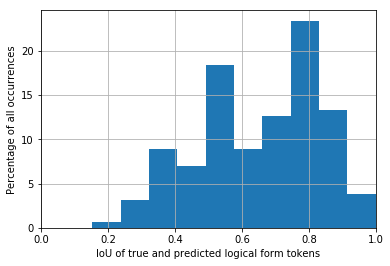

In [414]:
df_incorrect = df[~df.correct]
df_incorrect['gold_tokens'] = df_incorrect.gold.str.split().apply(lambda x: set(x)).apply(lambda x: {a for a in x if len(a) > 1})
df_incorrect['pred_tokens'] = df_incorrect.pred.str.split().apply(lambda x: set(x)).apply(lambda x: {a for a in x if len(a) > 1})
h = df_incorrect.apply(lambda x: len(x['gold_tokens'].intersection(x['pred_tokens'])) / len(x['gold_tokens'].union(x['pred_tokens'])), axis=1)

h.hist(weights=100 * pd.np.ones_like(h) / len(h))  # )
plt.xlim([0, 1])
plt.xlabel('IoU of true and predicted logical form tokens')
_ = plt.ylabel('Percentage of all occurrences')


In [378]:
df[(df.pred.str.contains('_cityid') & df.gold.str.contains('_stateid')) | (df.gold.str.contains('_cityid') & df.pred.str.contains('_stateid'))]

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len
8,False,"( NV , ( _river ( V0 ) , _traverse ( V0 , NV ) , _state ( V0 ) , _next_to ( V0 , NV ) , _state (...",183,11,False,"( NV , ( _river ( V0 ) , _traverse ( V0 , NV ) , _state ( V0 ) , _next_to ( V0 , NV ) , _state (...",209,which rivers run through states that border the state with the capital austin ?,14
10,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( maryland ) ) ) )",76,5,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( maryland ) ) ) )",75,what is the population of maryland ?,7
38,False,"( NV , ( _population ( NV , V1 ) , _largest ( V0 , ( _city ( V0 ) , _loc ( V0 , NV ) , _const ( ...",152,10,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( ' new york ' , _ ) ) ) )",83,how many people live in the biggest city in new york state ?,13
96,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( <unk> , _ ) ) ) )",76,5,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( detroit ) ) ) )",75,how many people live in detroit ?,7
175,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( <unk> , <unk> ) ) ) )",80,5,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( arizona ) ) ) )",75,what is the population of tempe arizona ?,8
185,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( texas ) ) ) )",73,5,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( texas ) ) ) , V2 ) )",79,how much population does texas have ?,7
196,False,"( NV , _count ( NV , ( _capital ( V0 ) , _const ( NV , _stateid ( ' rhode island ' ) ) , _loc ( ...",116,7,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( ' rhode island ' ) ) ) , V2 ) )",90,how many capitals does rhode island have ?,8
208,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( <unk> , _ ) ) ) )",76,5,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( tucson ) ) ) )",74,what is the population of tucson ?,7
210,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( <unk> , <unk> ) ) ) )",80,5,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( minnesota ) ) ) )",77,how many people live in minneapolis minnesota ?,8
249,False,"( NV , _largest ( NV , ( _state ( V1 ) , _next_to ( V1 , NV ) , _const ( V0 , _stateid ( nevada ...",131,8,False,"( NV , ( _state ( V0 ) , _const ( NV , _cityid ( nevada ) ) , _traverse ( V0 , V1 ) ) )",87,what state bordering nevada has the largest population ?,9


In [367]:
df[df.src.str.contains('miami')]

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len
169,False,"( NV , ( _state ( V0 ) , _const ( NV , _cityid ( <unk> , _ ) ) , _loc ( V0 , V1 ) ) )",85,6,True,"( NV , ( _state ( V0 ) , _const ( NV , _cityid ( miami ) ) , _loc ( V0 , V1 ) ) )",81,what state is miami in ?,6


In [266]:
df[df.src.str.contains('maryland')]

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len
10,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( maryland ) ) ) )",76,5,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( maryland ) ) ) )",75,what is the population of maryland ?,7
135,True,"( NV , _lowest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( maryland ) )...",102,7,False,"( NV , _lowest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( maryland ) )...",102,where is the lowest point in maryland ?,8


In [267]:
df[df.src.str.contains('tucson')]

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len
208,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( <unk> , _ ) ) ) )",76,5,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( tucson ) ) ) )",74,what is the population of tucson ?,7


In [268]:
df[df.src.str.contains('utah')]

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len
63,True,"( NV , ( _state ( V0 ) , _next_to ( V0 , NV ) , _const ( V0 , _stateid ( utah ) ) ) )",85,6,False,"( NV , ( _state ( V0 ) , _next_to ( V0 , NV ) , _const ( V0 , _stateid ( utah ) ) ) )",85,give me the states that border utah ?,8
68,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( utah ) ) ) )",72,5,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( utah ) ) ) )",72,how many people reside in utah ?,7
268,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( utah ) ) ) )",72,5,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( utah ) ) ) )",71,what is the population of utah ?,7


In [269]:
df[df.src.str.contains('mountains')]

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len
182,False,"( NV , ( _loc ( NV , V1 ) , _mountain ( V0 ) ) )",48,4,False,"( NV , _state ( V0 ) )",22,where are mountains ?,4


In [270]:
df[df.src.str.contains('washington')]

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len
105,False,"( NV , _largest ( V0 , ( _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( washington ...",105,7,False,"( NV , _largest ( V0 , ( _state ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( washington ...",105,what is the largest river in washington state ?,9
151,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( washington ) ) ) )",78,5,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _stateid ( washington ) ) ) )",78,what is the population of washington ?,7


In [271]:
df.groupby('correct').src_len.describe()

,count,mean,std,min,25%,50%,75%,max
correct,,,,,,,,
False,158.0,9.335443,2.731302,4.0,7.0,9.0,11.0,23.0
True,122.0,7.803279,1.644622,4.0,7.0,8.0,8.0,14.0


In [272]:
df.groupby('correct').gold_len.describe()

,count,mean,std,min,25%,50%,75%,max
correct,,,,,,,,
False,158.0,103.322785,34.053399,41.0,79.00,101.5,123.00,310.0
True,122.0,93.729508,17.636850,41.0,82.25,93.0,102.75,146.0


In [273]:
df.groupby('correct').pred_len.describe()

,count,mean,std,min,25%,50%,75%,max
correct,,,,,,,,
False,158.0,94.449367,29.803934,22.0,73.00,89.5,106.00,238.0
True,122.0,93.729508,17.636850,41.0,82.25,93.0,102.75,146.0


In [274]:
df.groupby('correct').gold_parens.describe()

,count,mean,std,min,25%,50%,75%,max
correct,,,,,,,,
False,158.0,7.069620,2.105852,3.0,5.25,7.0,8.0,20.0
True,122.0,6.360656,1.083807,3.0,6.00,6.0,7.0,9.0


In [275]:
(df
 .assign(gold_src_diff=df.gold_len - df.src_len)
 .query('gold_src_diff > 150'))

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len,gold_src_diff
8,False,"( NV , ( _river ( V0 ) , _traverse ( V0 , NV ) , _state ( V0 ) , _next_to ( V0 , NV ) , _state (...",183,11,False,"( NV , ( _river ( V0 ) , _traverse ( V0 , NV ) , _state ( V0 ) , _next_to ( V0 , NV ) , _state (...",209,which rivers run through states that border the state with the capital austin ?,14,169
72,False,"( NV , _count ( NV , ( _state ( V0 ) , _loc ( NV , V1 ) , _low_point ( V1 , V0 ) , <unk> ( V0 , ...",197,11,True,"( NV , ( _state ( V0 ) , _const ( NV , _riverid ( alabama ) , _traverse ( V0 , V1 ) ) ) ) alabama",97,count the states which have elevations lower than what alabama has ?,12,185
188,False,"( NV , ( _state ( V0 ) , _loc ( NV , V1 ) , _highest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) ,...",198,13,False,"( NV , ( _state ( V0 ) , _next_to ( V0 , NV ) , _highest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV...",185,what state contains the highest point of those the colorado river traverses ?,13,185
257,False,"( NV , _count ( NV , ( _state ( V0 ) , _loc ( NV , V1 ) , _higher ( V0 , NV ) , _place ( V1 ) , ...",310,20,True,"( NV , _count ( NV , ( _state ( V0 ) , _loc ( NV , V1 ) , _river ( V0 ) , _loc ( V0 , NV ) , _st...",238,how many states have a higher point than the highest point of the state with the largest capital...,23,287
259,False,"( NV , _largest ( V0 , ( _city ( V0 ) , _loc ( V0 , NV ) , _smallest ( V0 , ( _state ( V0 ) , _c...",168,11,False,"( NV , _largest ( V0 , ( _city ( V0 ) , _loc ( V0 , NV ) , _largest ( V0 , ( _state ( V0 ) , _lo...",156,what is the largest city in smallest state through which the mississippi runs ?,14,154


In [276]:
# df.assign(gold_src_diff=df.gold_len - df.src_len).boxplot(column='gold_src_diff', by='correct')

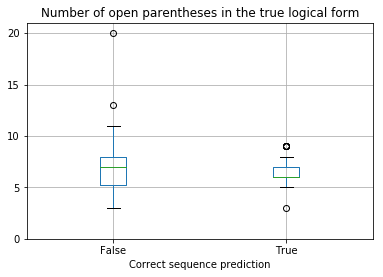

In [277]:
df.boxplot(column='gold_parens', by='correct')
plt.suptitle('')
plt.title('Number of open parentheses in the true logical form')
plt.xlabel('Correct sequence prediction')
plt.ylim([0, 21])
_ = plt.yticks([0, 5, 10, 15, 20])

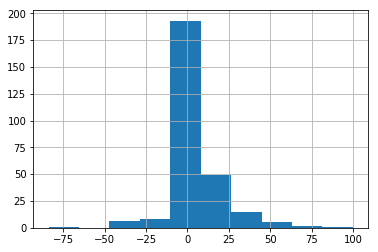

In [124]:
(df.gold_len - df.pred_len).hist()

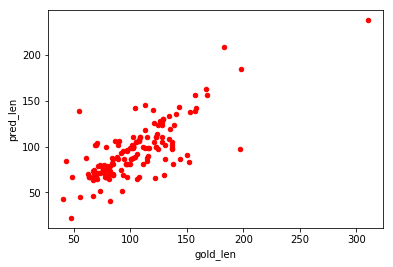

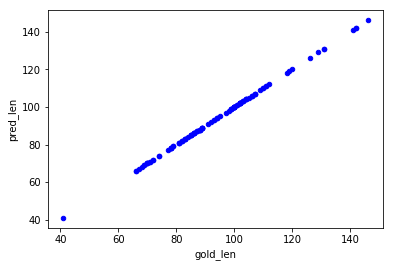

In [168]:
for g, group in df.groupby('correct'):
    group.plot(kind='scatter', x='gold_len', y='pred_len', color='b' if g else 'r')
plt.show()

,correct,gold,gold_len,gold_parens,gold_unk,pred,pred_len,src,src_len,gold_src_diff
0,False,"( NV , _smallest ( V0 , _state ( V0 ) ) )",41,3,False,"( NV , _smallest ( V0 , _capital ( V0 ) ) )",43,which state is the smallest ?,6,35
1,True,"( NV , _longest ( V0 , ( _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _countryid ( usa ) ) )...",100,7,False,"( NV , _longest ( V0 , ( _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _countryid ( usa ) ) )...",100,which is the longest river in usa ?,8,92
2,False,"( NV , _highest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _state ( V0 ) ) ) )",79,6,False,"( NV , _highest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _countryid ( usa ) ) )...",100,what are the highest points of all the states ?,10,69
3,False,"( NV , ( _major ( V0 ) , _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( ohio ) ) ) )",97,7,False,"( NV , ( _major ( V0 ) , _city ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( ohio ) ) ) )",96,what are the major rivers in ohio ?,8,89
4,False,"( NV , ( _major ( V0 ) , _river ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( florida ) )...",100,7,False,"( NV , ( _major ( V0 ) , _city ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( florida ) ) ) )",99,name the major rivers in florida ?,7,93
5,False,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( <unk> , <unk> ) ) ) )",80,5,True,"( NV , ( _population ( NV , V1 ) , _const ( V0 , _cityid ( pennsylvania ) ) ) )",79,what is the population of erie pennsylvania ?,8,72
6,False,"( NV , _smallest ( NV , ( _state ( V1 ) , _density ( V1 , V0 ) ) ) )",68,5,False,"( NV , _largest ( NV , ( _state ( V1 ) , _density ( V1 , V0 ) ) ) )",67,what state has the lowest population density ?,8,60
7,False,"( NV , ( _loc ( NV , V1 ) , _smallest ( V0 , _city ( V0 ) ) ) )",63,5,False,"( NV , _smallest ( NV , ( _city ( V1 ) , _population ( V1 , V0 ) ) ) )",70,where is the smallest city ?,6,57
8,False,"( NV , ( _river ( V0 ) , _traverse ( V0 , NV ) , _state ( V0 ) , _next_to ( V0 , NV ) , _state (...",183,11,False,"( NV , ( _river ( V0 ) , _traverse ( V0 , NV ) , _state ( V0 ) , _next_to ( V0 , NV ) , _state (...",209,which rivers run through states that border the state with the capital austin ?,14,169
9,True,"( NV , _lowest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( massachusett...",107,7,False,"( NV , _lowest ( V0 , ( _place ( V0 ) , _loc ( V0 , NV ) , _const ( V0 , _stateid ( massachusett...",107,what is the lowest point in massachusetts ?,8,99


### attention debug

In [363]:
!scp scicomp2:cs224n-project/attn_co .

attn_co                                       100% 1150KB   1.0MB/s   00:01    


In [278]:
!scp scicomp2:cs224n-project/attn .

attn                                          100% 1166KB 593.9KB/s   00:01    


In [360]:
example = """
                 what         is        the     lowest      point         in    idaho          ? 
   _answer  0.0000760  0.0000074  0.0000001  0.0006852 *0.9992192  0.0000043  0.0000000  0.0000000 
         (  0.0000036  0.0000014  0.0000106  0.0000000  0.0002707 *0.9994457  0.0002052  0.0000000 
        NV  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000419 *0.9999582  0.0000000 
         ,  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *0.9999998  0.0000002  0.0000000 
   _lowest  0.0000000  0.0000000  0.0000000 *0.9994855  0.0005144  0.0000000  0.0000000  0.0000000 
         (  0.0000000  0.0000000  0.0000229  0.0000000  0.0000000  0.0001603 *0.9998090  0.0000000 
        V0  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         ,  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000  0.0000000 
         (  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0013995 *0.9986004  0.0000000 
    _place  0.0000001  0.0000000  0.0000000  0.0000000  0.0002725  0.4067148 *0.5930094  0.0000000 
         (  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *0.9913055  0.0086945  0.0000000 
        V0  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         )  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *0.9382017  0.0617983  0.0000000 
         ,  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000180 *0.9999820  0.0000000 
      _loc  0.0000017  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *0.9999968  0.0000012 
         (  0.0000001  0.0000000  0.0000041  0.0000000  0.0000000  0.0000000 *0.9999845  0.0000000 
        V0  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         ,  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000  0.0000000 
        NV  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         )  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000016 *0.9999985  0.0000000 
         ,  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *0.9976870  0.0023130  0.0000000 
    _const  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         (  0.0000052  0.0000002  0.0000016  0.0000000  0.0000000  0.0000000 *0.9999735  0.0000000 
        V0  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         ,  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000  0.0000000 
  _stateid  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         (  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
     idaho  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         )  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000425 *0.9999574  0.0000000 
         )  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         )  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000  0.0000000 *1.0000000  0.0000000 
         )  0.0000002  0.0000000  0.0000000  0.0000000  0.0000000  0.0000020 *0.9999979  0.0000000 
         )  0.0493225  0.0000001  0.0000000  0.0000000  0.0000000  0.0028308 *0.9477875  0.0000589 
      </s> *0.9690093  0.0012425  0.0000000  0.0000000  0.0000000  0.0000003  0.0000000  0.0297305
"""

In [361]:
def attn_heatmap(example: str) -> None:
    vals = [' '.join(x.strip().replace('*', '').split()).split() for x in example.strip().split('\n')]
    headers = vals[0]
    rows = [map(float, v[1:]) for v in vals[1:]]
    indices = [v[0] for v in vals[1:]]
    df_attn = pd.DataFrame(rows, columns=headers, index=indices)
    ax = sns.heatmap(df_attn, cmap="YlGnBu", xticklabels=True,yticklabels=True)
    ax.xaxis.set_ticks_position('top')
    ax.set_yticklabels(ax.get_yticklabels(), rotation =0)
    ax.set_xticklabels(ax.get_xticklabels(), rotation =90)
    # plt.title('Correlation between different fearures')

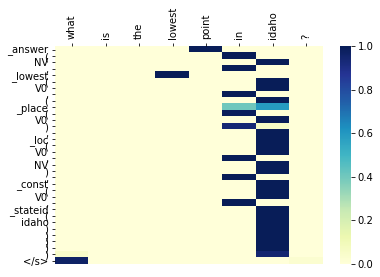

In [362]:
attn_heatmap(example)

### older attempts

In [17]:
!pip install python-Levenshtein

Looking in indexes: https://smartiproxy.mgmt.netflix.net/pypi


In [1]:
from experiments import ExperimentRunner
import params

In [2]:
exp = ExperimentRunner(params.experiment1_test, 1)

In [3]:
exp.uuid

'0a7c63314af944219a589e5f9d998d31'

In [4]:
tuple(sorted(exp.__dict__.items()))

(('experiment_parameters',
  {'augment': {None},
   'pre_train': {False},
   'lr': {0.1},
   'decoder_type': {'rnn'},
   'domain_name': {'geoquery'},
   'aug_frac': {1.0},
   'embed_size': {128},
   'hidden_size': {128},
   'seed': {0},
   'dropout': {0.3},
   'cuda': {False},
   'batch_size_train': {256},
   'batch_size_dev': {128},
   'valid_niter': {100},
   'max_epoch': {5},
   'beam_size': {5},
   'max_sentence_length': {1000},
   'encoder_type': {'brnn'},
   'file_path_train': {'data/geo880_train600.tsv'},
   'file_path_dev': {'data/geo880_test280.tsv'},
   'file_path_model': {'model.bin'}}),
 ('n_jobs', 1),
 ('uuid', '0a7c63314af944219a589e5f9d998d31'))

In [5]:
param_grid = exp._get_param_grid(exp.experiment_parameters)

In [6]:
import run

In [24]:
runner = run.Runner(**param_grid[0])

In [25]:
import hashlib

In [28]:
hashlib.sha224(bytearray('_'.join([f'{k}_{v}' for k, v in frozenset(runner.__dict__.items())]), 'utf8')).hexdigest()

'5e7621a769cc753f025f68a33c1fc3bad7fd9f598818f518eabdd454'

In [29]:
a = {'a': 1, 'c': 2, 'b': 3}

In [31]:
sorted(a.keys())

['a', 'b', 'c']

In [40]:
from typing import Dict

In [41]:
def hash_dict(d: Dict) -> str:
    dict_str_rep = '_'.join([f'{key}_{d[key]}' for key in sorted(d.keys())])
    return hashlib.sha224(bytearray(dict_str_rep, 'utf8')).hexdigest()

In [82]:
from typing import NamedTuple, Optional

In [83]:
class ExperimentResults(NamedTuple):
    sequence_correct: int
    sequence_total: int
    sequence_accuracy: float
    token_correct: int
    token_total: int
    token_accuracy: float
    denotation_correct: Optional[int]
    denotation_total: Optional[int]
    denotation_accuracy: Optional[float]

In [86]:
a = ExperimentResults(1, 2, 3, 4, 5, 6, 7, 8, 9)

In [90]:
b = a._asdict()

In [116]:
from typing import List, Tuple, Set
from collections import defaultdict
DomainDataTokenized = List[Tuple[List[str], List[str]]]
DomainDataString = List[Tuple[str, str]]


from grammar import Grammar
from utils import stopwords

class CoOccurrence:
    def __init__(self, src_tgt: DomainDataString):
        self.window_size = 3
        self.token_size_threshold = 3
        self.support = 0.3
        self.support_abs = 2
        self.aug_prob = 0.5

        self.src_tgt = src_tgt
        self.lexicon_src_tgt = self._generate_lexicon(self.src_tgt, is_reverse=False)
        self.lexicon_tgt_src = self._generate_lexicon([(y, x) for x, y in self.src_tgt], is_reverse=True)

    def _generate_lexicon(self, src_tgt: DomainDataString, is_reverse: bool = False) -> Dict[str, Set[str]]:
        cnt = defaultdict(lambda: defaultdict(int))
        cnt_tgt = defaultdict(int)

        # _answer appears everywhere for target -> source
        stop_words = set(stopwords).union({'_answer'} if is_reverse else set())

        for src, tgt in src_tgt:
            src_tokens = src.split()
            tgt_tokens = tgt.split()

            for tgt_token in tgt_tokens:
                cnt_tgt[tgt_token] += 1

            for i, src_token in enumerate(src_tokens):
                if len(src_token) >= self.token_size_threshold and src_token not in stop_words:
                    for j in range(-self.window_size, self.window_size + 1):
                        if (0 <= i + j < len(tgt_tokens) and len(tgt_tokens[i + j]) >= self.token_size_threshold and
                                tgt_tokens[i + j] not in stop_words):
                            cnt[tgt_tokens[i + j]][src_token] += 1

        # set of src words that positionally (within a window) co-occur with some min support with the target
        x = {
            tgt: {src: cnt[tgt][src] for src in cnt[tgt] if
                  cnt[tgt][src] >= self.support * cnt_tgt[tgt] and cnt[tgt][src] >= self.support_abs}
            for tgt in cnt
            if
            len({src for src in cnt[tgt] if
                 cnt[tgt][src] >= self.support * cnt_tgt[tgt] and cnt[tgt][src] >= self.support_abs}) >= 2
        }

        # lookup for co-occurring tokens
        out = defaultdict(set)
        for val_dict in x.values():
            val_vals = val_dict.keys()
            for val in val_vals:
                for val_map_to in val_vals:
                    if val_map_to != val:
                        out[val].add(val_map_to)

        return out

    def _aug(self, token: str, src: bool) -> str:
        lexicon = self.lexicon_src_tgt if src else self.lexicon_tgt_src
        if token in lexicon:
            do_aug = random.random() <= self.aug_prob
            return random.choice(list(lexicon[token])) if do_aug else token
        else:
            return token

    def _sample_item(self, x_str: str, y_str: str) -> Tuple[str, str]:
        x_lst, y_lst = x_str.split(), y_str.split()
        xs_aug = ' '.join([self._aug(x, src=True) for x in x_lst])
        ys_aug = ' '.join([self._aug(y, src=False) for y in y_lst])
        return xs_aug, ys_aug

    # def sample(self, n) -> CoOccurrenceData:
    #     src_tgt_n = random.sample(self.src_tgt, n)
    #     return [self._sample_item(x_str, y_str) for x_str, y_str in src_tgt_n]

    def __call__(self, src_tgt: DomainDataString, n: Optional[int] = None) -> DomainDataString:
        if n:
            src_tgt = random.sample(src_tgt, n)
        return [self._sample_item(x_str, y_str) for x_str, y_str in src_tgt]

In [117]:
import random

In [120]:
co = CoOccurrence([('a b c', 'c d e'), ('a b c', 'a d e')])

In [123]:
co([('a b', 'c d')], 2)

ValueError: Sample larger than population or is negative

In [70]:
class A:
    def __init__(self, a):
        self.a = a
        self.uuid = self._get_uuid()
        self.c = a + 1
        
    def _get_uuid(self):
        return hash_dict(self.__dict__)

In [71]:
a = A(5)

In [72]:
a.uuid

'62357b2f9297ef4295f9c41d8f259a9f0c100d1ff67b518ef3525a52'

In [77]:
a.c = 20

In [78]:
a.uuid

'62357b2f9297ef4295f9c41d8f259a9f0c100d1ff67b518ef3525a52'

In [38]:
a.b['b']['b']['b']

{'a': 5, 'b': {...}}

In [175]:
data = 'data/geo880_train600.tsv'
src_tgt = [line.strip().split('\t') for line in open(data)]

In [180]:
srcs = [set(src.split()) for src, _ in src_tgt]

co_occur_map = defaultdict(set)

co_occur = [
    (list(b.difference(c))[0], list(c.difference(b))[0])
    for b in srcs
    for c in srcs
    if (b != c
        and len(b.intersection(c)) == len(b) - 1
        and len(b) == len(c)
        and list(b.difference(c))[0] not in stopwords
        and list(c.difference(b))[0] not in stopwords)
]

for a, b in co_occur:
    co_occur_map[a].add(b)
    co_occur_map[b].add(a)
    
co_occur_map

defaultdict(set,
            {'florida': {'arizona',
              'california',
              'colorado',
              'country',
              'delaware',
              'kansas',
              'louisiana',
              'ohio',
              'texas',
              'us',
              'wyoming'},
             'us': {'alaska',
              'america',
              'arizona',
              'california',
              'colorado',
              'country',
              'florida',
              'georgia',
              'idaho',
              'iowa',
              'kansas',
              'mississippi',
              'nebraska',
              'ohio',
              'oregon',
              'pennsylvania',
              'texas',
              'usa',
              'wyoming'},
             'wyoming': {'arizona',
              'california',
              'colorado',
              'country',
              'delaware',
              'florida',
              'georgia',
              'kansas',
      

In [186]:
co_occur_map['california']

{'alaska',
 'america',
 'arizona',
 'atlanta',
 'austin',
 'chicago',
 'dallas',
 'delaware',
 'denver',
 'florida',
 'hawaii',
 'idaho',
 'illinois',
 'kalamazoo',
 'kansas',
 'louisiana',
 'maine',
 'minnesota',
 'mississippi',
 'missouri',
 'montana',
 'ohio',
 'oklahoma',
 'oregon',
 'pennsylvania',
 'riverside',
 'sacramento',
 'seattle',
 'states',
 'texas',
 'us',
 'washington',
 'wisconsin',
 'wyoming'}

In [183]:
co_occur_map['alaska']

{'alabama',
 'arizona',
 'arkansas',
 'california',
 'colorado',
 'delaware',
 'georgia',
 'hawaii',
 'idaho',
 'iowa',
 'kentucky',
 'maine',
 'massachusetts',
 'michigan',
 'missouri',
 'nebraska',
 'ohio',
 'seattle',
 'states',
 'tennessee',
 'texas',
 'us',
 'usa',
 'washington',
 'wisconsin'}

In [ ]:
[
    for src, _ in src_tgt
    for i, x in enumerate(src.split())
]

In [142]:
Counter([
    (i, x)
    for src, _ in src_tgt
    for i, x in enumerate(src.split())
    if len(x) >= 3 and x not in stopwords
]).most_common()

[((1, 'many'), 90),
 ((1, 'states'), 63),
 ((1, 'state'), 60),
 ((3, 'population'), 41),
 ((2, 'border'), 34),
 ((4, 'city'), 32),
 ((4, 'point'), 31),
 ((2, 'states'), 31),
 ((4, 'river'), 28),
 ((2, 'people'), 26),
 ((3, 'highest'), 25),
 ((1, 'rivers'), 24),
 ((7, 'state'), 24),
 ((3, 'capital'), 23),
 ((3, 'live'), 22),
 ((4, 'cities'), 22),
 ((3, 'largest'), 22),
 ((4, 'state'), 21),
 ((3, 'major'), 20),
 ((6, 'state'), 20),
 ((2, 'rivers'), 19),
 ((5, 'river'), 18),
 ((6, 'states'), 17),
 ((3, 'longest'), 17),
 ((6, 'texas'), 16),
 ((3, 'area'), 15),
 ((3, 'biggest'), 15),
 ((3, 'cities'), 15),
 ((3, 'lowest'), 14),
 ((5, 'population'), 14),
 ((5, 'texas'), 13),
 ((8, 'state'), 13),
 ((5, 'states'), 11),
 ((3, 'states'), 11),
 ((4, 'highest'), 11),
 ((3, 'smallest'), 11),
 ((4, 'largest'), 11),
 ((2, 'run'), 11),
 ((2, 'major'), 10),
 ((3, 'border'), 10),
 ((7, 'states'), 10),
 ((5, 'city'), 9),
 ((3, 'shortest'), 9),
 ((0, 'give'), 9),
 ((6, 'river'), 9),
 ((2, 'cities'), 9),
 (

In [130]:


Counter([
    (x, y)
    for src, tgt in src_tgt
    for i, (x, y) in enumerate(zip(src.split(), tgt.split()))
    if distance(x, y) <= 2 and len(x) >= 3 and len(y) >= 3
])

NameError: name 'distance' is not defined

In [41]:
friends = set()
friends.union({1, 2, 3})

{1, 2, 3}

In [58]:
friends = []

window_size = 5
distance_threshold = 3
token_size_threshold = 3

for src, tgt in src_tgt:
    src_tokens = src.split()
    tgt_tokens = tgt.split()
    
    for i, src_token in enumerate(src_tokens):
        if len(src_token) >= token_size_threshold:
            friends += [
                (src_token, tgt_tokens[i + j])
                for j in range(-window_size, window_size + 1)
                if (0 <= i + j < len(tgt_tokens) and len(tgt_tokens[i + j]) >= token_size_threshold and distance(tgt_tokens[i + j], src_token) <= distance_threshold)
            ]

In [59]:
Counter(friends)

Counter({('highest', '_highest'): 26,
         ('state', '_state'): 62,
         ('mountain', '_mountain'): 4,
         ('capital', '_capital'): 25,
         ('populations', '_population'): 7,
         ('name', '_lake'): 1,
         ('lakes', '_lake'): 4,
         ('states', '_state'): 96,
         ('population', '_population'): 37,
         ('rivers', '_river'): 31,
         ('lowest', '_lowest'): 14,
         ('capitals', '_capital'): 4,
         ('size', '_size'): 5,
         ('shortest', '_shortest'): 9,
         ('river', '_river'): 32,
         ('major', '_major'): 27,
         ('most', '_most'): 13,
         ('long', '_len'): 7,
         ('the', '_len'): 18,
         ('area', '_area'): 15,
         ('longest', '_longest'): 21,
         ('smallest', '_smallest'): 21,
         ('largest', '_largest'): 42,
         ('city', '_city'): 26,
         ('over', '_river'): 1,
         ('are', '_lake'): 1,
         ('density', '_density'): 8,
         ('mountains', '_mountain'): 1,
       

In [61]:
tuples = [
    (x, y)
    for src, tgt in src_tgt
    for i, (x, y) in enumerate(zip(src.split(), tgt.split()))
    # if distance(x, y) <= 2 and len(x) >= 3 and len(y) >= 3
]

In [62]:
from collections import defaultdict

In [73]:
cnt = defaultdict(lambda: defaultdict(int))

In [74]:
for src, tgt in tuples:
    if len(src) >= 3 and len(tgt) >= 3:
        cnt[tgt][src] += 1

In [81]:
for src in cnt['_city']:
    print(src)

the
are
border
pennsylvania
usa
virginia
texas
citizens
borders
california
population


In [ ]:
{
    ''
}

{'_answer': {'what': 384, 'which': 53, 'how': 111, 'where': 17},
 '_largest': {'state': 13, 'city': 19}}

In [102]:
from nltk.corpus import stopwords

In [134]:
def generate_lexicon(src_tgt, is_reverse=False):
    cnt = defaultdict(lambda: defaultdict(int))
    cnt_tgt = defaultdict(int)

    window_size = 3
    # distance_threshold = 3
    token_size_threshold = 3
    support = 0.3
    support_abs = 2
    stop_words = set(stopwords.words('english')).union({'_answer'} if is_reverse else set())


    for src, tgt in src_tgt:
        src_tokens = src.split()
        tgt_tokens = tgt.split()

        for tgt_token in tgt_tokens:
            cnt_tgt[tgt_token] += 1

        for i, src_token in enumerate(src_tokens):
            if len(src_token) >= token_size_threshold and src_token not in stop_words:
                for j in range(-window_size, window_size + 1):
                    if (0 <= i + j < len(tgt_tokens) and len(tgt_tokens[i + j]) >= token_size_threshold and tgt_tokens[i + j] not in stop_words):
                        cnt[tgt_tokens[i + j]][src_token] += 1

    x = {
        tgt: {src: cnt[tgt][src] for src in cnt[tgt] if cnt[tgt][src] >= support * cnt_tgt[tgt] and cnt[tgt][src] >= support_abs}
        for tgt in cnt
        if len({src for src in cnt[tgt] if cnt[tgt][src] >= support * cnt_tgt[tgt] and cnt[tgt][src] >= support_abs}) >= 2
    }
    
    out = defaultdict(set)
    for val_dict in x.values():
        val_vals = val_dict.keys()
        for val in val_vals:
            for val_map_to in val_vals:
                if val_map_to != val:
                    out[val].add(val_map_to)
                    
    return out

In [146]:
random.sample([(1, 2), (3, 4), (5, 6)], 2)

[(1, 2), (3, 4)]

In [140]:
import random

In [143]:
random.random()

0.6232124459954171

In [144]:
random.choice({1, 2, 3})

TypeError: 'set' object does not support indexing

In [115]:
tgt_src = 

In [136]:
generate_lexicon(src_tgt, is_reverse=False)

defaultdict(set,
            {'highest': {'point'},
             'point': {'highest', 'lowest'},
             'lakes': {'states'},
             'states': {'borders',
              'cities',
              'lakes',
              'least',
              'many',
              'population',
              'rivers',
              'state'},
             'lowest': {'point'},
             'many': {'cities', 'rivers', 'states'},
             'cities': {'major', 'many', 'rivers', 'states'},
             'rivers': {'cities', 'many', 'states'},
             'shortest': {'river'},
             'river': {'length', 'longest', 'shortest'},
             'major': {'cities'},
             'state': {'borders',
              'largest',
              'least',
              'population',
              'smallest',
              'states'},
             'length': {'river'},
             'longest': {'river'},
             'smallest': {'population', 'state'},
             'population': {'density', 'smallest', 'state

In [137]:
generate_lexicon(tgt_src, is_reverse=True)

defaultdict(set,
            {'_state': {'_count',
              '_density',
              '_largest',
              '_population',
              '_river'},
             '_river': {'_city', '_longest', '_population', '_state'},
             '_lake': {'_major'},
             '_major': {'_count', '_lake'},
             '_population': {'_river', '_state'},
             '_count': {'_major', '_state'},
             '_largest': {'_density', '_state'},
             '_density': {'_area', '_largest', '_state'},
             '_place': {'_loc'},
             '_loc': {'_place'},
             '_area': {'_density'},
             '_longest': {'_river'},
             '_city': {'_river'},
             '_smallest': {'_fewest'},
             '_fewest': {'_smallest'}})

In [192]:
co = CoOccurrence(src_tgt)

In [193]:
co.lexicon_tgt_src

defaultdict(set,
            {'_state': {'_count',
              '_density',
              '_largest',
              '_population',
              '_river'},
             '_river': {'_city', '_longest', '_population', '_state'},
             '_lake': {'_major'},
             '_major': {'_count', '_lake'},
             '_population': {'_river', '_state'},
             '_count': {'_major', '_state'},
             '_largest': {'_density', '_state'},
             '_density': {'_area', '_largest', '_state'},
             '_place': {'_loc'},
             '_loc': {'_place'},
             '_area': {'_density'},
             '_longest': {'_river'},
             '_city': {'_river'},
             '_smallest': {'_fewest'},
             '_fewest': {'_smallest'}})

In [197]:
co.sample(5)

[('what is the biggest city in usa ?',
  '_answer ( A , _largest ( A , ( _city ( A ) , _loc ( A , B ) , _const ( B , _countryid ( usa ) ) ) ) )'),
 ('what cities in texas have the highest number of citizens ?',
  '_answer ( A , _density ( B , ( _city ( A ) , _loc ( A , C ) , _const ( C , _stateid ( texas ) ) , _state ( A , B ) ) ) )'),
 ('what states border hawaii ?',
  '_answer ( A , ( _state ( A ) , _next_to ( A , B ) , _const ( B , _stateid ( hawaii ) ) ) )'),
 ('where is mount whitney ?',
  "_answer ( A , ( _place ( B , A ) , _const ( B , _placeid ( ' mount whitney ' ) ) ) )"),
 ('where is the lowest spot in iowa ?',
  '_answer ( A , _lowest ( A , ( _loc ( A ) , _place ( A , B ) , _const ( B , _stateid ( iowa ) ) ) ) )')]